In [1]:
import numpy as np
import pandas as pd
import urllib
import requests
import json
import io
import datetime

from matplotlib import pyplot as plt

In [2]:
org = pd.read_csv('data.csv')

In [3]:
org

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT
0,Alkoholunfälle,insgesamt,2024,202401,NaN,NaN,NaN,NaN,NaN
1,Alkoholunfälle,insgesamt,2024,202402,NaN,NaN,NaN,NaN,NaN
2,Alkoholunfälle,insgesamt,2024,202403,NaN,NaN,NaN,NaN,NaN
3,Alkoholunfälle,insgesamt,2024,202404,NaN,NaN,NaN,NaN,NaN
4,Alkoholunfälle,insgesamt,2024,202405,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2249,Verkehrsunfälle,Verletzte und Getötete,2000,200008,647.0,NaN,-13.04,NaN,584.0
2250,Verkehrsunfälle,Verletzte und Getötete,2000,200009,675.0,NaN,4.33,NaN,594.0
2251,Verkehrsunfälle,Verletzte und Getötete,2000,200010,615.0,NaN,-8.89,NaN,596.0
2252,Verkehrsunfälle,Verletzte und Getötete,2000,200011,578.0,NaN,-6.02,NaN,594.0


In [4]:
org['MONATSZAHL'].unique()

array(['Alkoholunfälle', 'Fluchtunfälle', 'Verkehrsunfälle'], dtype=object)

In [5]:
def process_per_category(df_full, category):
    df = df_full[df_full['JAHR'] <= 2020]
    df = df[df['MONATSZAHL'] == category]
    df = df[df['AUSPRAEGUNG'] == 'insgesamt']
    df = df[df['MONAT'] != 'Summe']
    
    df['PERIOD'] = pd.to_datetime(df['MONAT'], format='%Y%m')
    df = df.sort_values(by='PERIOD')

    fig = plt.figure(figsize=(6,4))
    plt.plot(df['PERIOD'], df['WERT'])
    plt.title(f'{category}')
    return df

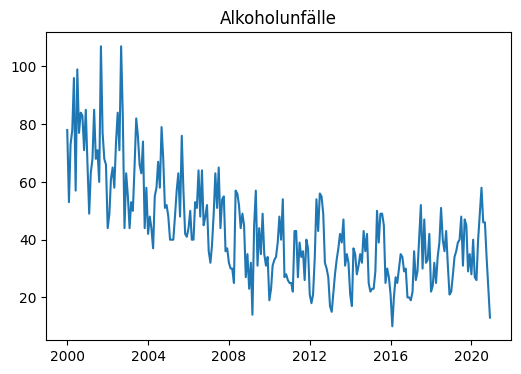

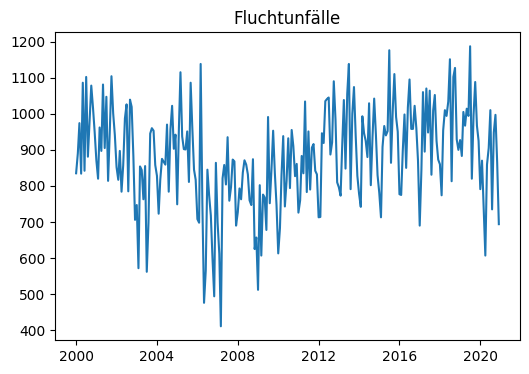

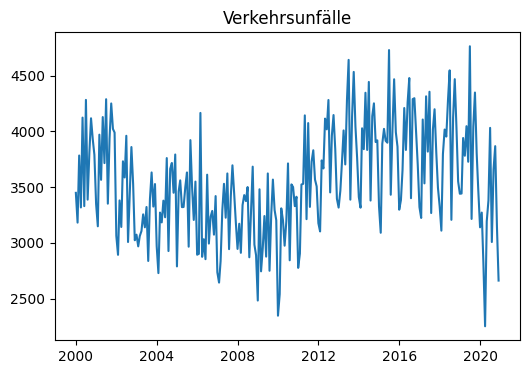

In [6]:
dfs = []
for cat in org['MONATSZAHL'].unique():
    df_cat = process_per_category(org, cat)
    dfs.append(df_cat)